<a href="https://colab.research.google.com/github/spdsp04/Gesture_Recognition/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
![1607_2716_0 (1)](https://user-images.githubusercontent.com/93203186/172011187-70099885-05f6-4e4a-9dbe-e4db30471f54.jpg)


> Imagine working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
> The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Stop: Pause the movie

## Understanding  Dataset
> The training data consist of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). 
>These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

> The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. 
> These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images).
> Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

> Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

> Here task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects). We have withheld the test folder for evaluation purposes - your final model's performance will be tested on the 'test' set.
 
 ## Goals of the Project

> __Generator:__  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

> __Model:__ Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

> __Write up:__ This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [12]:
# Importing necessary libraries

import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import abc
from sys import getsizeof

import warnings
warnings.filterwarnings("ignore")


We set the random seed so that the results don't vary drastically.

In [13]:
# Setting seed value

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

## Loading Dataset

Loading file for training and validation data.
Setting the `batch_size` here.

In [14]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())



### Selecting Batch Size and epochs for all the model.

In [15]:
num_epochs = 20       # choose the number of epochs
batch_size = 40        # choose the number of batch

## Generator

This is one of the most important part of the code. The overall structure of the generator has been given here. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. (We can experiment with `img_idx`, `y`,`z` and normalization until we can get high accuracy)

In [16]:
# Defining for Cropping and Resizing images

def cropAndResize(image,HEIGHT_DIMENSION,WIDTH_DIMENSION):
    # Crop the images and resize.  
    # Note that the images are of 2 different shape  &  conv3D will throw error if the inputs in a batch are of different shapes.
    # Croping (making aspect ratio same)
    
    if abs(image.shape[0]-image.shape[1])%2==0 and image.shape[0]!=image.shape[1]:
        dimension_diff=abs(image.shape[0]-image.shape[1])
        cropping_ratio=dimension_diff//2
        if image.shape[0]>image.shape[1]:
            image=image[cropping_ratio:image.shape[0]-cropping_ratio,:,:]
        elif image.shape[0]<image.shape[1]:
            image=image[:,cropping_ratio:image.shape[1]-cropping_ratio,:]
                    
    # Resizing
    if image.shape[0]>120 or image.shape[1]>120:
        image=resize(image, (120, 120))
    return image

In [17]:
# Defining Generator function

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = 7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24 #create a list of image no's you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size                 # calculate the number of batches
        remaining_batch_size=len(t)%batch_size
        for batch in range(num_batches):                 # we iterate over the number of batches
            batch_data = np.zeros((batch_size,16,120,120,3)) # x is the no. of images you use for each video,(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))      # batch_labels is the one hot representation of the output
            for folder in range(batch_size):             # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # Read all the images in the folder
                for idx,item in enumerate(img_idx):      # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image_resized = cropAndResize(image,120,120)    
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255         # Normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255         # Normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255         # Normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels                # you yield the batch_data and the batch_labels
            
        for batch in range(num_batches,num_batches+1):    # iterate over the number of batches
            batch_data = np.zeros((remaining_batch_size*2,16,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size*2,5))       # batch_labels is the one hot representation of the output
            for folder in range(remaining_batch_size):                # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = cropAndResize(image,120,120)                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255        #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255        #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255        #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Video is represented above in the generator as (number of images, height, width, number of channels). 

In [18]:
# Fuction for plotting results on graph

from matplotlib import pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [19]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('Validation sequences =', num_val_sequences)
print ('Epochs =', num_epochs)

Training sequences = 663
Validation sequences = 100
Epochs = 20


## Model

Design the network in such a way that the model is able to give good accuracy on the least number of parameters.

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,LSTM,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers

img_idx = 7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24 

input_shape = (len(img_idx), 120, 120, 3)

np.random.seed(30)

### Model 1: Simple Conv3D Model


In [10]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Total params: 25,749,637, Trainable params: 25,749,637, Non-trainable params: 0

2023-01-12 01:54:08.883699: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-01-12 01:54:08.883764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [24]:
# creating the `train_generator` and the `val_generator` which is used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR, earlystop]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
    
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
    
else:
    validation_steps = (num_val_sequences//batch_size) + 1



1. Once a model is created, next step is to `compile` the model.
2. In the `summary` of the model, we will see the total number of parameters to train the model.
2. Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
3. `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

These steps are going to be same for all the model.

In [25]:
optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 118, 118, 32)  2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 116, 116, 64)  55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 6, 58, 58, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 56, 56, 128)    2

In [13]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/20


2023-01-12 01:54:14.250633: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 2.5663 - categorical_accuracy: 0.2099Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.28942, saving model to model_init_2023-01-1201_54_08.192592/model-00001-2.56631-0.20991-1.28942-0.21667.h5
17/17 [==============================] - 66s 4s/step - loss: 2.5663 - categorical_accuracy: 0.2099 - val_loss: 1.2894 - val_categorical_accuracy: 0.2167 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.3398 - categorical_accuracy: 0.3907
Epoch 00002: val_loss improved from 1.28942 to 1.08940, saving model to model_init_2023-01-1201_54_08.192592/model-00002-1.33982-0.39067-1.08940-0.35833.h5
17/17 [==============================] - 66s 4s/step - loss: 1.3398 - categorical_accuracy: 0.3907 - val_loss: 1.0894 - val_categorical_accuracy: 0.3583 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.9866 - categorical_accur

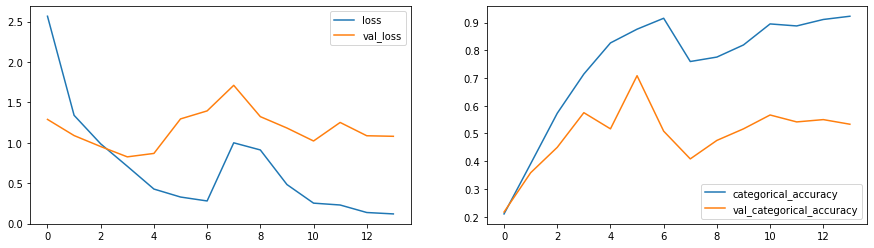

In [14]:
plot(history)

### Model Conclusion

#### Model Accuracy on the train set is  92% and on validation set is 53%
#### Model is Overfitting

### Model 2: Conv3D with BatchNormalization Model


In [15]:
 model = Sequential()

 model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
 model.add(Conv3D(64, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))
 model.add(BatchNormalization())

 model.add(Conv3D(128, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())

 model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())
 model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
 model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())

 model.add(Flatten())
 model.add(Dense(512, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))
    
 # Total params: 20,900,613,Trainable params: 20,897,669, Non-trainable params: 2,944

In [16]:

model_name = 'model_init2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 14, 118, 118, 32)  2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 12, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 6, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 4, 28, 28, 128)  

In [17]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 2.5235 - categorical_accuracy: 0.4913
Epoch 00001: val_loss improved from inf to 16.52966, saving model to model_init2_2023-01-1201_54_08.192592/model-00001-2.52347-0.49125-16.52966-0.20000.h5
17/17 [==============================] - 82s 5s/step - loss: 2.5235 - categorical_accuracy: 0.4913 - val_loss: 16.5297 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.9643 - categorical_accuracy: 0.6064
Epoch 00002: val_loss improved from 16.52966 to 3.82273, saving model to model_init2_2023-01-1201_54_08.192592/model-00002-0.96434-0.60641-3.82273-0.19167.h5
17/17 [==============================] - 67s 4s/step - loss: 0.9643 - categorical_accuracy: 0.6064 - val_loss: 3.8227 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.5908 - categorical_accuracy: 0.7668
Epoch 00003: val_loss did not improv

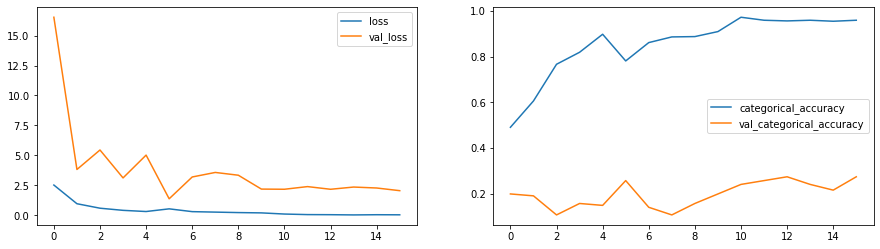

In [18]:
plot(history)

### Model Conclusion

#### Model Accuracy on the train set is  95% and on validation set is 27%
#### Model is Overfitting

### Model 3: Conv3D with BatchNormalization,Dropout


In [26]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

# Total params: 20,900,613 , Trainable params: 20,897,669, Non-trainable params: 2,944

In [27]:

model_name = 'model_init3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
   os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 14, 118, 118, 32)  2624      
                                                                 
 conv3d_7 (Conv3D)           (None, 12, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 6, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 6, 58, 58, 64)     0         
                                                                 
 conv3d_8 (Conv3D)           (None, 4, 56, 56, 128)   

In [28]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                   callbacks=callbacks_list, validation_data=val_generator, 
                   validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/20


2023-01-12 07:24:30.784089: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 2.2288 - categorical_accuracy: 0.4125Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 4.39572, saving model to model_init3_2023-01-1207_22_50.672875/model-00001-2.22879-0.41254-4.39572-0.24167.h5
17/17 [==============================] - 89s 5s/step - loss: 2.2288 - categorical_accuracy: 0.4125 - val_loss: 4.3957 - val_categorical_accuracy: 0.2417 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.0101 - categorical_accuracy: 0.5816
Epoch 00002: val_loss improved from 4.39572 to 2.32434, saving model to model_init3_2023-01-1207_22_50.672875/model-00002-1.01011-0.58163-2.32434-0.15000.h5
17/17 [==============================] - 71s 4s/step - loss: 1.0101 - categorical_accuracy: 0.5816 - val_loss: 2.3243 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.7847 - categorical_acc

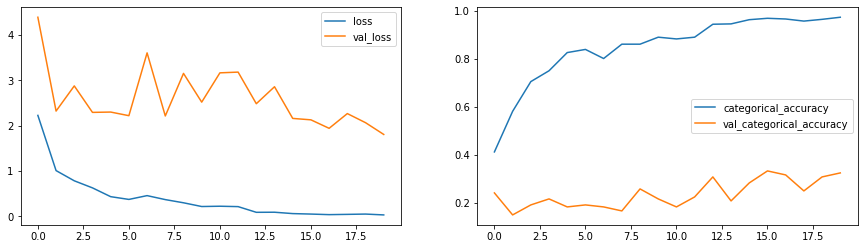

In [29]:
plot(history)

### Model Conclusion

#### Model Accuracy on the train set is  97% and on validation set is 32%
#### Model is Overfitting

### LSTM MODELS

### Model 4: Conv 2D + LSTM


In [30]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

#Total params: 124,165, Trainable params: 123,589, Non-trainable params: 576


In [31]:

model_name = 'model_init4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 16, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 16, 59, 59, 32)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 57, 57, 64)   18496     
 tributed)                                            

In [32]:
 history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.5189 - categorical_accuracy: 0.3907
Epoch 00001: val_loss improved from inf to 1.33425, saving model to model_init4_2023-01-1207_22_50.672875/model-00001-1.51892-0.39067-1.33425-0.18333.h5
17/17 [==============================] - 64s 4s/step - loss: 1.5189 - categorical_accuracy: 0.3907 - val_loss: 1.3343 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.1118 - categorical_accuracy: 0.4810
Epoch 00002: val_loss improved from 1.33425 to 1.33346, saving model to model_init4_2023-01-1207_22_50.672875/model-00002-1.11176-0.48105-1.33346-0.20833.h5
17/17 [==============================] - 62s 4s/step - loss: 1.1118 - categorical_accuracy: 0.4810 - val_loss: 1.3335 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.9098 - categorical_accuracy: 0.5962
Epoch 00003: val_loss improved from 1.33

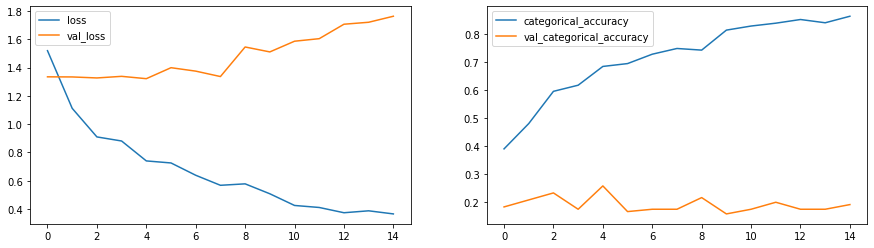

In [33]:
plot(history)

### Model Conclusion

#### Model Accuracy on the train set is  86% and on validation set is 19%
#### Model is Overfitting

### Model 5: Conv2D + GRU


In [34]:
 model = Sequential()
 model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(TimeDistributed(GlobalAveragePooling2D()))
 model.add(TimeDistributed(Dense(64, activation='relu')))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(GRU(128))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))

# Total params: 99,845, Trainable params: 99,269, Non-trainable params: 576


In [35]:

model_name = 'model_init5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 16, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_14 (Bat  (None, 16, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 16, 59, 59, 32)    0         
                                                                 
 time_distributed_8 (TimeDis  (None, 16, 57, 57, 64)   18496     
 tributed)                                            

In [36]:
 history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.4077 - categorical_accuracy: 0.4038
Epoch 00001: val_loss improved from inf to 1.33835, saving model to model_init5_2023-01-1207_22_50.672875/model-00001-1.40769-0.40379-1.33835-0.12500.h5
17/17 [==============================] - 63s 4s/step - loss: 1.4077 - categorical_accuracy: 0.4038 - val_loss: 1.3383 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.1219 - categorical_accuracy: 0.4592
Epoch 00002: val_loss improved from 1.33835 to 1.33145, saving model to model_init5_2023-01-1207_22_50.672875/model-00002-1.12193-0.45918-1.33145-0.16667.h5
17/17 [==============================] - 65s 4s/step - loss: 1.1219 - categorical_accuracy: 0.4592 - val_loss: 1.3315 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.9308 - categorical_accuracy: 0.5962
Epoch 00003: val_loss did not improve fr

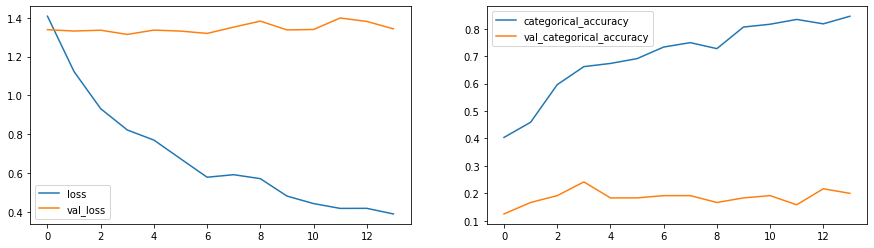

In [37]:
 plot(history)

### Model Conclusion

#### Model Accuracy on the train set is  83% and on validation set is 15%
#### Model is Overfitting

### Model with Trasnfer learning

### Model 6: Transfer Learning (VGG16) + LSTM Model


In [38]:
 from keras.applications.vgg16 import VGG16
 VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
 model = Sequential()
 model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
 for layer in model.layers:
     layer.trainable = False

 model.add(TimeDistributed(BatchNormalization()))
 model.add(TimeDistributed(MaxPooling2D((2, 2))))
 model.add(TimeDistributed(Flatten()))
 model.add(LSTM(128))
 model.add(Dropout(0.25))
 model.add(Dense(64,activation='relu'))
 model.add(Dropout(0.25))
       
 model.add(Dense(5, activation='softmax'))

# Total params: 15,053,509 , Trainable params: 337,797 , Non-trainable params: 14,715,712

58900480/58889256 [==============================] - 2s 0us/step


In [39]:

model_name = 'model_init6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 3, 3, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 3, 3, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 1, 1, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 512)          0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [40]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.5241 - categorical_accuracy: 0.3003
Epoch 00001: val_loss improved from inf to 1.24920, saving model to model_init6_2023-01-1207_22_50.672875/model-00001-1.52406-0.30029-1.24920-0.25000.h5
17/17 [==============================] - 69s 4s/step - loss: 1.5241 - categorical_accuracy: 0.3003 - val_loss: 1.2492 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.1322 - categorical_accuracy: 0.5452
Epoch 00002: val_loss improved from 1.24920 to 1.10944, saving model to model_init6_2023-01-1207_22_50.672875/model-00002-1.13222-0.54519-1.10944-0.40000.h5
17/17 [==============================] - 61s 4s/step - loss: 1.1322 - categorical_accuracy: 0.5452 - val_loss: 1.1094 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.8411 - categorical_accuracy: 0.7070
Epoch 00003: val_loss improved from 1.10

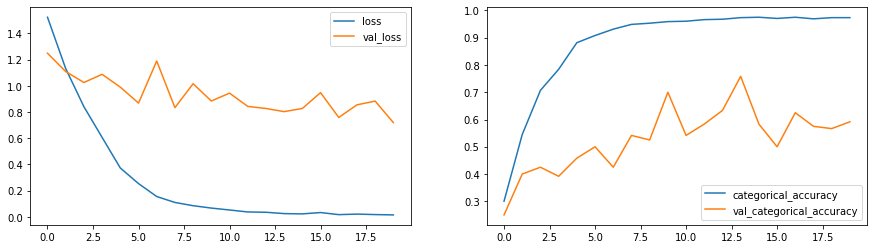

In [41]:
 plot(history)

### Model Conclusion

#### Model Accuracy on the train set is  96% and on validation set is 57%
#### Model is Overfitting

### Model 7: VGG16 + GRU


In [42]:
 from keras.applications.vgg16 import VGG16
 VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
 model = Sequential()
 model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
 for layer in model.layers:
     layer.trainable = False

 model.add(TimeDistributed(BatchNormalization()))
 model.add(TimeDistributed(MaxPooling2D((2, 2))))
 model.add(TimeDistributed(Flatten()))
 model.add(GRU(128))
 model.add(BatchNormalization())
 model.add(Dropout(0.25))
 model.add(Dense(64,activation='relu'))
 model.add(Dropout(0.5))
        
 model.add(Dense(5, activation='softmax'))

 # Total params: 14,972,357, Trainable params: 256,389, Non-trainable params: 14,715,968
   

In [43]:


model_name = 'model_init7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 3, 3, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 1, 1, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 512)          0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [44]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 2.1432 - categorical_accuracy: 0.2682
Epoch 00001: val_loss improved from inf to 1.33708, saving model to model_init7_2023-01-1207_22_50.672875/model-00001-2.14315-0.26822-1.33708-0.30000.h5
17/17 [==============================] - 66s 4s/step - loss: 2.1432 - categorical_accuracy: 0.2682 - val_loss: 1.3371 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.4215 - categorical_accuracy: 0.4548
Epoch 00002: val_loss improved from 1.33708 to 1.16650, saving model to model_init7_2023-01-1207_22_50.672875/model-00002-1.42153-0.45481-1.16650-0.40833.h5
17/17 [==============================] - 64s 4s/step - loss: 1.4215 - categorical_accuracy: 0.4548 - val_loss: 1.1665 - val_categorical_accuracy: 0.4083 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.1009 - categorical_accuracy: 0.5700
Epoch 00003: val_loss improved from 1.16

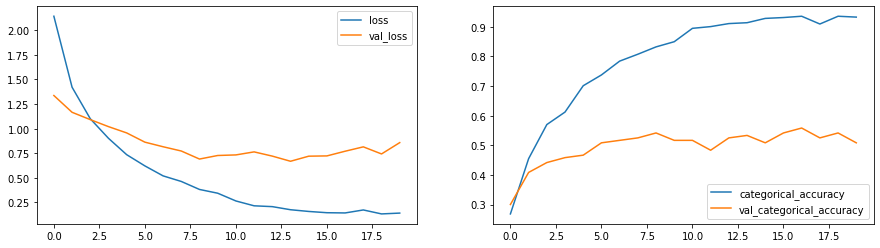

In [45]:
 plot(history)

### Model Conclusion

#### Model Accuracy on the train set is  94% and on validation set is 75%
#### Model is Overfitting

## Final Model
### Model 8: TransferLearning(Mobilenet) + GRU Model

In [46]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
 
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

# Total params: 20,900,613, Trainable params: 20,897,669 , Non-trainable params: 2,944

17235968/17225924 [==============================] - 2s 0us/step


### Compile 
After the model creation, the next step is to `compile` the model. In`summary` of the model, we'll see the total number of parameters to train.

In [47]:
optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 128)              

In [48]:
# creating the `train_generator` and the `val_generator` which is used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [49]:
model_name = 'model_init8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR, earlystop]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [50]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Fit Model

Now fit the model. This will start training the model and with the help of the checkpoints, we'll be able to save the model at the end of each epoch.

In [51]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.1631 - categorical_accuracy: 0.5437Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 0.95682, saving model to model_init8_2023-01-1207_22_50.672875/model-00001-1.16307-0.54373-0.95682-0.40833.h5
17/17 [==============================] - 70s 4s/step - loss: 1.1631 - categorical_accuracy: 0.5437 - val_loss: 0.9568 - val_categorical_accuracy: 0.4083 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.3712 - categorical_accuracy: 0.8397
Epoch 00002: val_loss improved from 0.95682 to 0.48265, saving model to model_init8_2023-01-1207_22_50.672875/model-00002-0.37115-0.83965-0.48265-0.61667.h5
17/17 [==============================] - 65s 4s/step - loss: 0.3712 - categorical_accuracy: 0.8397 - val_loss: 0.4826 - val_categorical_accuracy: 0.6167 - lr: 0.0010
Epoch 3/20
17/

### Plot graph

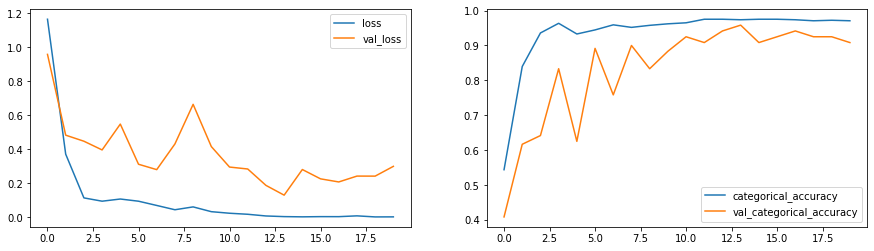

In [52]:
plot(history)

### Model Conclusion

#### Model Accuracy on the train set is  97% and on validation set is 99%
#### Model is Overfitting

#### Output .h5 File

#### https://drive.google.com/drive/folders/1UnirheRb6YLq7rGRpp6m135h20IpsQ2P?usp=share_link